## Entrenament del classificador basat en AlexNet

In [2]:
! pip install torchsummary

In [3]:
#imports necessaris

import torch
import torchvision
from torchvision import transforms
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
from torchsummary import summary
import time
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

torch.cuda.empty_cache()

In [4]:
#trasformació necessaria per redimensionar i passar-ho a tensor
data_transforms = transforms.Compose([
    transforms.Resize([112, 112]),
    transforms.ToTensor()
    ])

In [5]:
#Hiperparàmetres

BATCH_SIZE = 256
learning_rate = 0.001
EPOCHS = 15
numClasses = 43

In [6]:
! ls ../input/gtsrb-german-traffic-sign/

Meta  Meta.csv	Test  Test.csv	Train  Train.csv  meta	test  train


In [7]:
# Define path of training data

train_data_path = "../input/gtsrb-german-traffic-sign/Train"
train_data = torchvision.datasets.ImageFolder(root = train_data_path, transform = data_transforms)

# Divideix les dades
ratio = 0.8
n_train_examples = int(len(train_data) * ratio)
n_val_examples = len(train_data) - n_train_examples

train_data, val_data = data.random_split(train_data, [n_train_examples, n_val_examples])

print(f"# training = {len(train_data)}")
print(f"# val = {len(val_data)}")

# training = 31367
# val = 7842


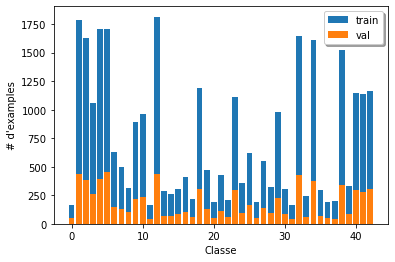

In [8]:
# Plot histogram for training and validation data

train_hist = [0]*numClasses
for i in train_data.indices:
    tar = train_data.dataset.targets[i]
    train_hist[tar] += 1
    
val_hist = [0]*numClasses
for i in val_data.indices:
    tar = val_data.dataset.targets[i]
    val_hist[tar] += 1

plt.bar(range(numClasses), train_hist, label="train")
plt.bar(range(numClasses), val_hist, label="val")
legend = plt.legend(loc='upper right', shadow=True)
plt.xlabel("Classe")
plt.ylabel("# d'examples")

plt.savefig("train_val_split.png", bbox_inches = 'tight', pad_inches=0.5)

In [9]:
# Carreguem les dades d'entrenament i validació

train_loader = data.DataLoader(train_data, shuffle=True, batch_size = BATCH_SIZE)
val_loader = data.DataLoader(val_data, shuffle=True, batch_size = BATCH_SIZE)

In [10]:
class AlexnetTS(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*7*7, 1000),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.5),
            nn.Linear(in_features=1000, out_features=256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256, output_dim)
            )
        
    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [11]:
# Instanciem el model
model = AlexnetTS(numClasses)
print(f'El model té {sum(p.numel() for p in model.parameters() if p.requires_grad):,} paràmetres entrenables')

# Definim optimitzador i funció de pèrdua
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

El model té 15,063,891 paràmetres entrenables


In [12]:
# Passa les coses a GPU
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [13]:
# Imprimeix info i arquitectura

print(model)
print(summary(model, (3, 112, 112))) 

AlexnetTS(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=12544, out_features=1000, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5,

In [14]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [15]:
# funció d'entrenament

def train(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    # Train the model
    model.train()
    
    for (images, labels) in loader:
        images = images.cuda()
        labels = labels.cuda()
        
        # Training pass
        opt.zero_grad()
        
        output, _ = model(images)
        loss = criterion(output, labels)
        
        # Backpropagation
        loss.backward()
        
        # Calculate accuracy
        acc = calculate_accuracy(output, labels)
        
        # Optimizing weights
        opt.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [16]:
# funció d'avaluació

def evaluate(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    # Evaluate the model
    model.eval()
    
    with torch.no_grad():
        for (images, labels) in loader:
            images = images.cuda()
            labels = labels.cuda()
            
            # Run predictions
            output, _ = model(images)
            loss = criterion(output, labels)
            
            # Calculate accuracy
            acc = calculate_accuracy(output, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [17]:
# Entrenament
train_loss_list = [0]*EPOCHS
train_acc_list = [0]*EPOCHS
val_loss_list = [0]*EPOCHS
val_acc_list = [0]*EPOCHS

for epoch in range(EPOCHS):
    print("Epoch-%d: " % (epoch))

    train_start_time = time.monotonic()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    train_end_time = time.monotonic()

    val_start_time = time.monotonic()
    val_loss, val_acc = evaluate(model, val_loader, optimizer, criterion)
    val_end_time = time.monotonic()
    
    train_loss_list[epoch] = train_loss
    train_acc_list[epoch] = train_acc
    val_loss_list[epoch] = val_loss
    val_acc_list[epoch] = val_acc
    
    print("Training: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (train_loss, train_acc, train_end_time - train_start_time))
    print("Validation: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (val_loss, val_acc, val_end_time - val_start_time))
    print("")

Epoch-0: 


KeyboardInterrupt: 

In [ ]:
# guardem el model
MODEL_FOLDER = "../Model"
if not os.path.isdir(MODEL_FOLDER):
    os.mkdir(MODEL_FOLDER)
    
PATH_TO_MODEL = MODEL_FOLDER + "/pytorch_classification_alexnetTS.pth"
if os.path.exists(PATH_TO_MODEL):
    os.remove(PATH_TO_MODEL)
torch.save(model.state_dict(), PATH_TO_MODEL)



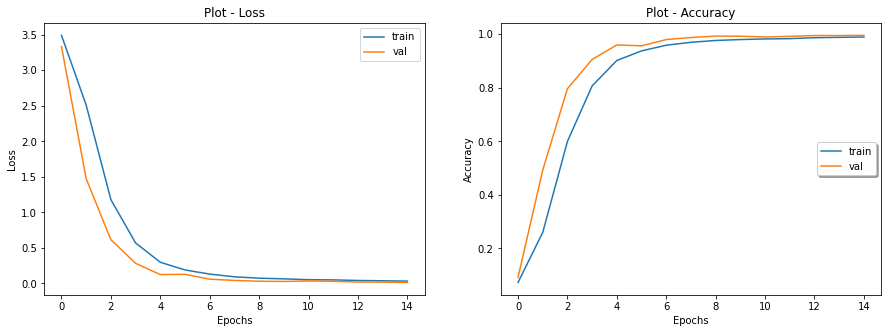

In [29]:
_, axs = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axs[0].plot(train_loss_list, label="train")
axs[0].plot(val_loss_list, label="val")
axs[0].set_title("Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
legend = axs[0].legend(loc='upper right', shadow=False)

# Accuracy plot
axs[1].plot(train_acc_list, label="train")
axs[1].plot(val_acc_list, label="val")
axs[1].set_title("Precissió")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Precissió")
legend = axs[1].legend(loc='center right', shadow=True)

In [68]:
! ls gtsrb/GTSRB/Final_Test/
! head gtsrb/GTSRB/Final_Test/Images/GT-final_test.test.csv

Images
Filename;Width;Height;Roi.X1;Roi.Y1;Roi.X2;Roi.Y2
00000.ppm;53;54;6;5;48;49
00001.ppm;42;45;5;5;36;40
00002.ppm;48;52;6;6;43;47
00003.ppm;27;29;5;5;22;24
00004.ppm;60;57;5;5;55;52
00005.ppm;52;56;5;5;47;51
00006.ppm;147;130;12;12;135;119
00007.ppm;32;33;5;5;26;28
00008.ppm;45;50;6;5;40;45


In [37]:
test_data_path = "../input/gtsrb-german-traffic-sign/Test/"
dataset_test = torchvision.datasets.GTSRB(root='./', split="test", transform = data_transforms, download=True)
data_loader = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=True, num_workers=1)

#test_data = torchvision.datasets.ImageFolder(root = test_data_path, transform = data_transforms)
#test_loader = data.DataLoader(test_data, batch_size=1, shuffle=False)


In [47]:
import pandas as pd
#df = pd.read_csv("../GTSRB/Test.csv")
#numExamples = len(df)

In [69]:
y_pred_list = []
corr_classified = 0
numExamples = 12630

with torch.no_grad():
    model.eval()

    i = 0

    for image, cat in data_loader:
        image = image.cuda()

        y_test_pred = model(image)

        y_pred_softmax = torch.log_softmax(y_test_pred[0], dim=1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
        y_pred_tags = y_pred_tags.cpu().numpy()
        
        y_pred = y_pred_tags[0]
        #y_pred = labels[y_pred]
        
        y_pred_list.append(y_pred)
        
        if int(cat) == y_pred:
            corr_classified += 1

        i += 1

print("Number of correctly classified images = %d" % corr_classified)
print("Number of incorrectly classified images = %d" % (numExamples - corr_classified))
print("Final accuracy = %f" % (corr_classified / numExamples))

KeyboardInterrupt: 

torch.Size([1, 3, 112, 112])
(tensor([[-24.9578, -11.1627, -24.2821,  -7.1880,  -8.1271, -17.9158, -31.4904,
         -29.2158, -25.3939, -18.1973, -15.4873,  -8.4468, -11.7861, -13.2704,
         -17.7872, -28.6401, -14.0604, -21.4921, -10.2319, -14.5113, -16.5371,
         -24.6534, -12.5567, -10.4971, -18.8988, -31.3146, -18.4905,  37.0359,
           0.1764,   8.7600,  -4.1586,   0.5248,  -2.7363,   4.8416, -19.1769,
           6.4642,  -9.3141,  -9.4704, -17.7210, -12.4162, -24.4200, -21.2984,
         -22.0907]], device='cuda:0', grad_fn=<AddmmBackward0>), tensor([[0.0000, 0.0000, 0.0000,  ..., 0.3035, 0.0000, 0.0526]],
       device='cuda:0', grad_fn=<ViewBackward0>))
tensor([27], device='cuda:0')


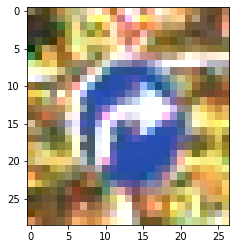

In [75]:
from torchvision.transforms import functional
from matplotlib import pyplot as plt
import cv2
import PIL

path = 'gtsrb/GTSRB/Final_Test/Images/'
img = cv2.imread(path + '00003.ppm')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
img = cv2.resize(img, (112, 112))

tensor = functional.to_tensor(img)
tensor = tensor[None, :]
print(tensor.shape)
model.eval()
out = model(tensor.cuda())
print(out)
y_pred_softmax = torch.log_softmax(out[0], dim=1)
_, y_pred_tags = torch.max(y_pred_softmax, dim=1)
print(y_pred_tags)